# New Section

In [ ]:
!nvidia-smi

Sun Feb 28 20:59:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 5.7MB/s 
     |████████████████████████████████| 3.2MB 40.7MB/s 
     |████████████████████████████████| 890kB 69.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=41f1284bf3c982af4256aebab1c7ab12cff9112e063c6d08c53691561f69f919
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
base_model = BertModel.from_pretrained("bert-base-uncased")

In [ ]:
path = '/content/drive/MyDrive/CMCL Shared Task/Cleaned_GECO_Dataset.csv'

In [ ]:
geco = pd.read_csv(path)
geco.drop(columns = ["Unnamed: 0"], inplace = True)
geco.head()

,WORD_ID,WORD,WORD_GAZE_DURATION,WORD_GO_PAST_TIME,WORD_TOTAL_READING_TIME,sentence_id
0,1-5-1,The,95,95,381,0
1,1-5-2,intense,54,582,828,0
2,1-5-3,interest,333,1097,565,0
3,1-5-4,aroused,78,2107,428,0
4,1-5-5,in,154,154,154,0


In [ ]:
def scale(df):
  df["WORD_GAZE_DURATION"] /= 10
  df["WORD_GO_PAST_TIME"] /= 10
  df["WORD_TOTAL_READING_TIME"] /= 10
  return
scale(geco)
geco.head()

,WORD_ID,WORD,WORD_GAZE_DURATION,WORD_GO_PAST_TIME,WORD_TOTAL_READING_TIME,sentence_id
0,1-5-1,The,9.5,9.5,38.1,0
1,1-5-2,intense,5.4,58.2,82.8,0
2,1-5-3,interest,33.3,109.7,56.5,0
3,1-5-4,aroused,7.8,210.7,42.8,0
4,1-5-5,in,15.4,15.4,15.4,0


In [ ]:
def add_token_per_words(df):
  n_tokens_per_word = []
  cdf = 0
  cf_n_token_per_word = []
  for i, word in enumerate(df.WORD):
    n_tokens_per_word.append(len(tokenizer.encode(word)) - 2)
    if (i > 0) and (df.loc[i-1, "sentence_id"] != df.loc[i, "sentence_id"]):
      cdf = 0
    cdf += len(tokenizer.encode(word)) - 2
    cf_n_token_per_word.append(cdf)
  df["n_tokens"] = n_tokens_per_word
  df["cf_n_tokens"] = cf_n_token_per_word
  return df

add_token_per_words(geco)
geco.head()

,WORD_ID,WORD,WORD_GAZE_DURATION,WORD_GO_PAST_TIME,WORD_TOTAL_READING_TIME,sentence_id,n_tokens,cf_n_tokens
0,1-5-1,The,9.5,9.5,38.1,0,1,1
1,1-5-2,intense,5.4,58.2,82.8,0,1,2
2,1-5-3,interest,33.3,109.7,56.5,0,1,3
3,1-5-4,aroused,7.8,210.7,42.8,0,1,4
4,1-5-5,in,15.4,15.4,15.4,0,1,5


In [ ]:
def form_sentences(df):
  sentences = []
  cdfs = []
  targets = []
  MAX_LEN = 0
  for i in range(8066):
    sentence = (' ').join(df[df.sentence_id == i].WORD)
    target = [list(ele) for ele in df[df.sentence_id == i].iloc[:, 2:5].values]
    cdf = list(np.array(df[df.sentence_id == i].loc[:, "cf_n_tokens"]))
    sentences.append(sentence)
    targets.append(target)
    cdfs.append(cdf)
    MAX_LEN = max(MAX_LEN, len(sentence.split()))
  return sentences, targets, cdfs, MAX_LEN

sentences, targets, cdfs, MAX_LEN = form_sentences(geco)
sentences[0]

"The intense interest aroused in the public by what was known at the time as 'The Styles Case' has now somewhat subsided. Nevertheless, in view of the world-wide notoriety which attended it, I have been asked, both by my friend Poirot and the family themselves, to write an account of the whole story. This, we trust, will effectually silence the sensational rumours which still persist. I will therefore briefly set down the circumstances which led to my being connected with the affair."

In [ ]:
MAX_LEN

143

In [ ]:
np.array(targets[0]).shape

(82, 3)

In [ ]:
from torch.utils.data import DataLoader, Dataset

class EyeGaze_dataset(Dataset):
  def __init__(self, sentencess, targets, cdfs, tokenizer):
    self.sentences = sentences               # List of Sentences
    self.targets = targets                   # List of Padded Targets
    self.tokenizer = tokenizer               # Tokenizer to be used (BERT)
    self.cdfs = cdfs                         # Cumulative Frequency Function
    #self.features = features
    #self.tags = tags
    
  def __len__(self):
    return len(self.sentences)               # No of Examples = 100

  def __getitem__(self, index):
    sentence = str(self.sentences[index])        # Get the review at the particular index
    target = self.targets[index]                    # Get the target label at the particular index
    cdf = self.cdfs[index]
    #feature = {}
    #for key in features.keys():
    #  feature[key] = features[key][index]
    #tag = tags[index]
    encoding = self.tokenizer.encode_plus(   # Encoder encoding the particular review
        sentence,
        return_attention_mask = True,
        padding = "max_length",
        max_length = 200,
        return_tensors = "pt"
    )
    # The class simply returns a dictionary of the following
    return_dict = {"target":torch.tensor(target, dtype = torch.float32),
                   "input_ids":encoding["input_ids"].flatten(),
                   "attention_mask":encoding["attention_mask"].flatten(),
                   "cdf": torch.tensor(cdf, dtype = torch.int16)}
                   
                   #"tag":torch.tensor(tag, dtype = torch.float32)}
    #for key in features.keys():
    #  return_dict[key] = torch.tensor(feature[key], dtype = torch.float32)

    return return_dict

In [ ]:
def create_data_loader(sentences, targets, cdfs, tokenizer, batch_size):
  data = EyeGaze_dataset(sentences, targets, cdfs, tokenizer)
  train_data_loader = DataLoader(data, batch_size = batch_size, shuffle = False)
  
  return train_data_loader

BATCH_SIZE = 1
data_loader = create_data_loader(sentences, targets, cdfs, tokenizer, BATCH_SIZE)

In [ ]:
temp = next(iter(data_loader))
print(temp.keys())
keys = ['target', 'input_ids', 'attention_mask', 'cdf']
for key in keys:
  print(temp[key].size())
m = 0
for d in data_loader:
  m = max(m, d["input_ids"].size()[1])
print(m)

dict_keys(['target', 'input_ids', 'attention_mask', 'cdf'])
torch.Size([1, 82, 3])
torch.Size([1, 200])
torch.Size([1, 200])
torch.Size([1, 82])
200


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class LanguageHeadLayer(torch.nn.Module):
  def __init__(self):
    super(LanguageHeadLayer, self).__init__()
    self.mid = torch.nn.Linear(in_features = base_model.config.hidden_size, out_features = 256)
    self.out = torch.nn.Linear(in_features = 256, out_features = 256)
    self.act1 = torch.nn.ReLU()
    self.act2 = torch.nn.GELU()
    self.drop = torch.nn.Dropout(p = 0.3)

  def forward(self, output):
    output = self.mid(output)
    output = self.act2(output)
    output = self.drop(output)

    return output

In [ ]:
class EyeGazeClassifier(torch.nn.Module):
  def __init__(self, num_targets = 3):
    super(EyeGazeClassifier, self).__init__()
    self.base_model = base_model
    self.languageheadlayer = LanguageHeadLayer()
    self.out = torch.nn.Linear(in_features = 256, out_features = num_targets)

  def map_predictions(self, outputs, attention_masks, cdfs):
    for i in range(outputs.size()[0]):    
      output = outputs[i]
      attention_mask = attention_masks[i]
      cdf = cdfs[i]

      #attention_mask[0] = 0
      #attention_mask[-1] = 0
      attention_mask = torch.unsqueeze(attention_mask, dim = 1)

      output = output*attention_mask

      pred_tensor = torch.unsqueeze(torch.mean(output[1:cdf[0]+1], dim = 0), dim = 0)

      for j in range(0, len(cdf)-1):
        if (cdf[j+1] != 0):
          y = torch.unsqueeze(torch.mean(output[cdf[j]+1:cdf[j+1]+1], dim = 0), dim = 0)
          pred_tensor = torch.cat((pred_tensor, y), dim = 0)

      #pred_pad = torch.tensor([[0 for a in range(768)] for k in range(MAX_LEN - pred_tensor.size()[0])], dtype = torch.float32).to(device)
      #pred_tensor = torch.cat((pred_tensor, pred_pad), dim = 0)
      if i==0:
        pred_tensors = torch.unsqueeze(pred_tensor, dim = 0)
      else:
        pred_tensors = torch.cat((pred_tensors, torch.unsqueeze(pred_tensor, dim = 0)), dim = 0)

    return pred_tensors

  def forward(self, input_ids, attention_mask, cdf):
    lang_output = self.base_model(input_ids = input_ids, attention_mask = attention_mask)
    lang_output = self.map_predictions(lang_output["last_hidden_state"], attention_mask, cdf)
    lang_output = self.languageheadlayer(lang_output)
    #feature_output = self.feature_model(extra_features)
    #output = (lang_output+feature_output)/2
    
    output = self.out(lang_output)
    
    return output

In [ ]:
#del model
model = EyeGazeClassifier(3)
model = model.to(device)

In [ ]:
#@title
def target_initialise():
  targets = {}
  outputs = {}

  targets["r20"] = torch.tensor([], dtype = torch.float32)
  targets["r21"] = torch.tensor([], dtype = torch.float32)
  targets["r22"] = torch.tensor([], dtype = torch.float32)
  
  outputs["pred_r20"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r21"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r22"] = torch.tensor([], dtype = torch.float32)
  
  return targets, outputs

In [ ]:
#@title
def store_targets(targets, target):
  targets["r20"] = torch.cat([targets["r20"], target[0,:,0].detach().cpu()], dim = 0)
  targets["r21"] = torch.cat([targets["r21"], target[0,:,1].detach().cpu()], dim = 0)
  targets["r22"] = torch.cat([targets["r22"], target[0,:,2].detach().cpu()], dim = 0)
  
  return targets  

def store_outputs(outputs, output):
  outputs["pred_r20"] = torch.cat([outputs["pred_r20"], output[0,:,0].detach().cpu()], dim = 0)
  outputs["pred_r21"] = torch.cat([outputs["pred_r21"], output[0,:,1].detach().cpu()], dim = 0)
  outputs["pred_r22"] = torch.cat([outputs["pred_r22"], output[0,:,2].detach().cpu()], dim = 0)
  
  return outputs

In [ ]:
EPOCHS = 1
from transformers import AdamW, get_linear_schedule_with_warmup

opt_params = [{"params": model.languageheadlayer.parameters()},
              {"params": model.out.parameters()}]

partial_optimizer = AdamW(opt_params, lr=2e-7, betas = (0.9, 0.999), correct_bias=False)
total_optimizer = AdamW(model.parameters(), lr = 6e-5, betas = (0.9, 0.999), correct_bias = False)

total_steps = len(data_loader) * EPOCHS

partial_scheduler = get_linear_schedule_with_warmup(
  partial_optimizer,
  num_warmup_steps=6,
  num_training_steps=total_steps
)

total_scheduler = get_linear_schedule_with_warmup(
  total_optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.L1Loss(reduction = "mean").to(device)  # reduction = "mean" can be used

In [ ]:
#@title
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [ ]:
def save(history, best):
  for key, value in history.items():
    best[key] = value[-1]

  return best

def update(history, train_loss, train_r2):
  
  history['train_loss'].append(train_loss)

  history["train_nFix"].append(train_r2["nFix"])
  history["train_GPT"].append(train_r2["GPT"])
  history["train_TRT"].append(train_r2["TRT"])


  return history

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
  model = model.train()

  losses = []
  targets, outputs = target_initialise()  
  r2 = {}
  with torch.autograd.set_detect_anomaly(True):
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      target = d["target"].to(device)
      cdf = d["cdf"].to(device)
      #char_len = torch.unsqueeze(d["n_chars"], dim = 2)
      #char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2)
      #if_stopword = torch.unsqueeze(d["stopword"], dim = 2)
      #if_num = torch.unsqueeze(d['number'], dim = 2)
      #if_end = torch.unsqueeze(d["endword"], dim = 2)
      #tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)
      #tag = d["tag"]

      targets = store_targets(targets, target)
      #extra_feature = torch.cat((char_len, char_len_lemmatized, if_stopword, if_num, if_end, tfidf, tag), dim = 2).to(device)

      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf,
        )

      outputs = store_outputs(outputs, output)
      
      loss = loss_fn(output, target)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
    
    r2["nFix"] = r2_score(targets["r20"].numpy(), outputs["pred_r20"].numpy())
    r2["GPT"] = r2_score(targets["r21"].numpy(), outputs["pred_r21"].numpy())
    r2["TRT"] = r2_score(targets["r22"].numpy(), outputs["pred_r22"].numpy())
    
  return np.mean(losses), r2    # correct_predictions.double() / n_examples,

In [ ]:
from collections import defaultdict

history = defaultdict(list)
tolerance = 0
best = {}
best = {"train_loss" : 10000}
early_stopping = EarlyStopping(patience = 5, verbose = True, delta = 0.001)

optimizer = total_optimizer
scheduler = total_scheduler

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 120)


  train_loss, train_r2 = train_epoch(model,
    data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler)
  

  print(f'Train loss {train_loss} and Train R2 {train_r2}')


  history = update(history, train_loss, train_r2)
  
  if train_loss < best["train_loss"]:
    best = save(history, best)
  
  early_stopping(train_loss, model)
  if early_stopping.early_stop:
    print("Stopped Early at at Epoch ", epoch+1)
    break
  model.load_state_dict(torch.load('checkpoint.pt'))

Epoch 1/1
------------------------------------------------------------------------------------------------------------------------
Train loss 14.329914672304376 and Train R2 {'nFix': 0.017769096554440034, 'GPT': -0.012850411684996121, 'TRT': 0.006025899502727916}
Validation loss decreased (inf --> 14.329915).  Saving model ...


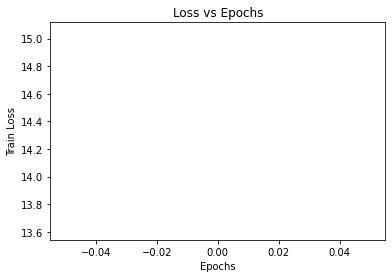

In [ ]:
plt.plot(history["train_loss"], c = "r")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
save_file_path = "/content/drive/My Drive/CMCL Shared Task/GecoBERT-agp.pth"
torch.save(model.state_dict(), save_file_path)

In [ ]:
len(data_loader)

8066

In [ ]:
'''
#training_data_file_path = "/content/drive/My Drive/CMCL Shared Task/training_data.csv"
freq_table_file_path = "/content/drive/MyDrive/CMCL Shared Task/unigram_freq.csv"
training_data_file_path = "/content/drive/MyDrive/CMCL Shared Task/training_data.csv"
freq_table = pd.read_csv(freq_table_file_path)
train_data = pd.read_csv(training_data_file_path)
'''

In [ ]:
'''
def remove_eos(df):
  cnt = 1
  endword = []
  for i in range(df.shape[0]-1):
    if (df.loc[i+1, "sentence_id"] == cnt):
      df.loc[i, "word"] = df.loc[i, "word"][:-6]   # Remove <EOS> for the last word of each sentence.
      cnt += 1
      endword.append(1)
    else:
      endword.append(-1) 
  s = df.loc[df.shape[0] - 1, "word"]              # Remove <EOS> for last element separately
  df.loc[df.shape[0] - 1, "word"] = s[:-6]
  endword.append(-1)
  df["endword"] = endword 
  return df
'''

In [ ]:
'''
def make_freq_col(df, freq_table):
  freq = []
  for word in df.word:
    if freq_table["count"][freq_table.word == word].size == 0:
      freq.append(0)
    else:
      freq.append(freq_table["count"][freq_table.word == word].item())
  df["freq"] = freq

  return df
'''

In [ ]:
'''
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def normalise_freq(df):
  df["freq"] = scaler.fit_transform(df["freq"].to_numpy().reshape(-1, 1))
  return df
'''

# CHECK DEBUGGING BEGIN



In [ ]:
'''
# output-> BERT outputs
# repeated values imply words breaking into tokens during tokenizer

output = torch.tensor([0.05, 1.0, 2, 2, 3, 4, 5, 6, 6, 6, 7, 9.5])

# 0.19 -> CLS token embedding
# 9.99 -> SEP token embedding

cdf = [1, 3, 4, 5, 6, 9, 10]
attention_mask  = torch.tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
map_predictions1(output, attention_mask, cdf)
'''

In [ ]:
'''
# COPIED FROM STANDARDISED ROBERTA FEATURES...
def map_predictions1(output, attention_mask, cdf):
  attention_mask[0][0] = 0
  attention_mask[0][-1] = 0
  attention_mask = torch.unsqueeze(attention_mask, dim = 2)
  output = torch.mul(output, attention_mask)[0]
  print("Output dims after mul = ", output.size())
  pred_tensor = torch.unsqueeze(torch.mean(output[1:cdf[0]+1], dim = 0), dim = 0)
  print("Pred tensor dims = ", pred_tensor.size())
  for i in range(0, len(cdf)-1):
    y = torch.unsqueeze(torch.mean(output[cdf[i]+1:cdf[i+1]+1], dim = 0), dim = 0)
    pred_tensor = torch.cat((pred_tensor, y), dim = 0)
  return pred_tensor
'''

In [ ]:
'''
words = ["Happy", "Birthday", "to", "Carlucci!"]    # Similar to words in df
sample_sent = (' ').join(words)                     # Forming sentences
encoding = tokenizer.encode_plus(sample_sent, add_special_tokens = True, return_attention_mask = True, return_tensors = "pt")   # Tokenize
encoding         
'''

In [ ]:
'''
# CALCULATE CF_TOKENS AS IN FUNCTION FROM NOTEBOOK STANDARDIZED ROBERTA ....
n_tokens_per_word = []
cdf = 0
cf_n = []
for i, word in enumerate(words):
  n_tokens_per_word.append(len(tokenizer.encode(word)) - 2)
  cdf += len(tokenizer.encode(word)) - 2
  cf_n.append(cdf)
cf_n
'''

In [ ]:
'''
# Output -> BERT output
# pred -> output after map predictions

output = base_model(input_ids = encoding["input_ids"], attention_mask = encoding["attention_mask"])["last_hidden_state"]
preds = map_predictions1(output, encoding["attention_mask"], cf_n)
output = torch.squeeze(output)
'''

# CHECK DEBUGGING END

In [ ]:
'''
#Using Pearson Correlation
plt.figure(figsize=(18,16))
corr = df.iloc[:, 2:].corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()
'''

In [ ]:
'''
from sklearn.feature_selection import f_classif

keys = ["nFix", "FFD", "GPT", "TRT", "fixProp"]
#for key in keys:
score = f_classif(df.loc[:, keys], df["tags"])
data = pd.DataFrame(data = score, columns = keys, index = ["F score", "p value"])
data
'''

In [ ]:
#score = f_classif(df.loc[:, keys], df["number"])
#data = pd.DataFrame(data = score, columns = keys, index = ["F score", "p value"])
#data

In [ ]:
#score = f_classif(df.loc[:, keys], df["stopword"])
#data = pd.DataFrame(data = score, columns = keys, index = ["F score", "p value"])
#data

In [ ]:
'''
from sklearn.feature_selection import f_classif

df = remove_eos(train_data)
keys = ["nFix", "FFD", "GPT", "TRT", "fixProp"]
score = f_classif(df.loc[:, keys], df["endword"])
data = pd.DataFrame(data = score, columns = keys, index = ["F score", "p value"])
data
'''

#CrisisNLP Code

#CrisisNLP Dataset Handling

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path= "/content/drive/MyDrive/ChiSquareX_NLP_Tutoring/Multi_Lingual/CrisisNLP_labeled_data/CrisisNLP_labeled_data_crowdflower/"

In [7]:
cd /content/drive/MyDrive/ChiSquareX_NLP_Tutoring/Multi_Lingual/CrisisNLP_labeled_data/CrisisNLP_labeled_data_crowdflower/

/content/drive/MyDrive/ChiSquareX_NLP_Tutoring/Multi_Lingual/CrisisNLP_labeled_data/CrisisNLP_labeled_data_crowdflower


In [8]:
pwd

'/content/drive/My Drive/ChiSquareX_NLP_Tutoring/Multi_Lingual/CrisisNLP_labeled_data/CrisisNLP_labeled_data_crowdflower'

In [9]:
ls

 2013_Pakistan_eq/                 2014_Middle_East_Respiratory_Syndrome_en/
 2014_California_Earthquake/       2014_Pakistan_floods/
 2014_Chile_Earthquake_cl/         2014_Philippines_Typhoon_Hagupit_en/
 2014_Chile_Earthquake_en/         2015_Cyclone_Pam_en/
 2014_ebola_cf/                    2015_Nepal_Earthquake_en/
 2014_Hurricane_Odile_Mexico_en/   README.txt
 2014_India_floods/               'Terms of use.txt'


In [10]:
cd 2014_Hurricane_Odile_Mexico_en/

/content/drive/My Drive/ChiSquareX_NLP_Tutoring/Multi_Lingual/CrisisNLP_labeled_data/CrisisNLP_labeled_data_crowdflower/2014_Hurricane_Odile_Mexico_en


In [42]:
ls

2014_Hurricane_Odile_Mexico_en_CF_labeled_data.tsv  labeling-instructions.txt


In [43]:
pwd

'/content/drive/MyDrive/ChiSquareX_NLP_Tutoring/Multi_Lingual/CrisisNLP_labeled_data/CrisisNLP_labeled_data_crowdflower/2014_Hurricane_Odile_Mexico_en'

In [44]:
import pandas as pd

In [45]:
data= pd.DataFrame()
data = pd.read_csv('2014_Hurricane_Odile_Mexico_en_CF_labeled_data.tsv', error_bad_lines=False, sep='\t') 

In [46]:
data.shape


(1262, 3)

In [47]:
data = data.drop("tweet_id", axis=1)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  1262 non-null   object
 1   label       1262 non-null   object
dtypes: object(2)
memory usage: 19.8+ KB


In [53]:
len(data[data['label'] == "not_related_or_irrelevant"])

43

In [54]:
data.loc[data.label == "not_related_or_irrelevant", 'not_related_or_irrelevant'] = 0
data.loc[data.label != 'not_related_or_irrelevant', 'label'] = 1

In [55]:
data

,tweet_text,label
0,Prayers for Cabo: Hurricane Odile Roars Throug...,1
1,Sammy Hagar's Home Damaged in Hurricane: Sammy...,1
2,"Residents, Tourists Sent to Shelters as Hurric...",1
3,Our thoughts go out to all of our friends in L...,1
4,Does anyone have information on emergency serv...,1
...,...,...
1257,"""In the wake of Hurricane Odile’s destruction ...",1
1258,LET'S HELP REBUILD BCS DEVASTATED BY HURRICANE...,1
1259,BBC News - Hurricane Odile damages Mexico's Ba...,1
1260,"Coachella, keep it safe, remnants arriving soo...",1


In [56]:
len(data[data['label'] == 0])

0

In [57]:
len(data[data['label'] == 1])

1262